Author : @leopauly | cnlp@leeds.ac.uk <br>
Description : Studying the feature vectors in the feature space

In [1]:
import os
from six.moves import xrange  
import PIL.Image as Image
import random
import numpy as np
import cv2
import time
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from keras import backend as K
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from skimage import io
import warnings
import scipy
warnings.filterwarnings('ignore')

# Custom scripts
import lscript as lsp
import modelling as md

Using TensorFlow backend.


In [2]:
height=112 
width=112 
channel=3
crop_size=112
cluster_length=16
feature_size=8192 

####  Loading model

In [3]:
## Defining placeholders in tf for images and targets
x_image = tf.placeholder(tf.float32, [None, cluster_length,height,width,channel],name='x') 
model_keras = md.C3D_ucf101_training_model_tf(summary=True)
out=model_keras(x_image)
y_pred = tf.nn.softmax(out)

print('Miscellenious items finished..!!',flush=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 16, 112, 112, 64)  5248      
_________________________________________________________________
pool1 (MaxPooling3D)         (None, 16, 56, 56, 64)    0         
_________________________________________________________________
conv2 (Conv3D)               (None, 16, 56, 56, 128)   221312    
_________________________________________________________________
pool2 (MaxPooling3D)         (None, 8, 28, 28, 128)    0         
_________________________________________________________________
conv3a (Conv3D)              (None, 8, 28, 28, 256)    884992    
_________________________________________________________________
conv3b (Conv3D)              (None, 8, 28, 28, 256)    1769728   
_________________________________________________________________
pool3 (MaxPooling3D)         (None, 4, 14, 14, 256)    0         
__________

####  Feature extraction and Distance calculation

In [4]:
## Start the session with logging placement.
saved_path='/nobackup/leopauly/S2l/'
init_op = tf.global_variables_initializer()
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False))
sess.run(init_op)

## Restore model weights from previously saved model
saver = tf.train.Saver()
saver.restore(sess, os.path.join(saved_path,'activity_model.ckpt-67'))
print("Model restored from file: %s" % saved_path,flush=True)

INFO:tensorflow:Restoring parameters from /nobackup/leopauly/S2l/activity_model.ckpt-67
Model restored from file: /nobackup/leopauly/S2l/


In [5]:
## Uniform sampling of frames
def get_compress_frames_data(filename, num_frames_per_clip=16):
  ''' Given a directory containing extracted frames, return a video clip of
  (num_frames_per_clip) consecutive frames as a list of np arrays '''
  ret_arr = []
  for parent, dirnames, filenames in os.walk(filename):

    filenames = sorted(filenames)
    jump=math.floor((len(filenames)/num_frames_per_clip))
    loop=0
    for i in range(0,len(filenames),jump):
      if (loop>15):
        break
      if (filenames[i].endswith('.png')):
        image_name = str(filename) + '/' + str(filenames[i])
        img = Image.open(image_name)
        img_data = np.array(img)
        ret_arr.append(img_data)
        loop=loop+1
  ret_arr=np.array(ret_arr) #ret_arr=ret_arr/255
  return np.array(ret_arr)

In [6]:
norm_order=2
def dist_calc(value_a,value_b):
    distance_=np.linalg.norm(value_a-value_b,ord=norm_order)
    return(distance_)

------------------------------------------------------------------------------------------------------------------

#### Manual Calculation

In [7]:
## Extraction of features 
def extract_video_features(vid,layername):
    vid_=vid.reshape(-1,cluster_length,height,width,channel)
    f_v = sess.graph.get_tensor_by_name(layername)
    #'flatten_1/Reshape:0' #dropout_1/cond/Merge:0 #fc8/BiasAdd:0 #Softmax:0 ('pool4/MaxPool3D:0')
    f_v_val=sess.run([f_v], feed_dict={'conv1_input:0':vid_,x_image:vid_,K.learning_phase(): 0 })
    features=np.reshape(f_v_val,(-1))
    return features

In [8]:
## Calculating distance

base_dir_D='/nobackup/leopauly/S2l/Leeds_Action_Dataset_6_7_2020/Reach n Push/multi_demo_0deg'

base_dir_a='/nobackup/leopauly/S2l/Leeds_Action_Dataset_6_7_2020/Incomplete multi/multi_robo_right'
base_dir_b='/nobackup/leopauly/S2l/Leeds_Action_Dataset_6_7_2020/Incomplete multi/multi_robo_misc'
base_dir_c='/nobackup/leopauly/S2l/Leeds_Action_Dataset_6_7_2020/Incomplete multi/multi_robo_incomp'
base_dir_d='/nobackup/leopauly/S2l/Leeds_Action_Dataset_6_7_2020/Incomplete multi/multi_robo_left'



base_dir_e='/nobackup/leopauly/S2l/Leeds_Action_Dataset_6_7_2020/Reach n Push/multi_robo'
#base_dir_g='/nobackup/leopauly/S2l/Leeds_Action_Dataset_6_7_2020/Reach n Push/multi_robo_comp1'


vid_D=get_compress_frames_data(base_dir_D)

vid_a=get_compress_frames_data(base_dir_a)
vid_b=get_compress_frames_data(base_dir_b)
vid_c=get_compress_frames_data(base_dir_c)
vid_d=get_compress_frames_data(base_dir_d)

vid_e=get_compress_frames_data(base_dir_e)
#vid_g=get_compress_frames_data(base_dir_f)

In [9]:
feature_dist_a=dist_calc(extract_video_features(vid_D,'flatten_1/Reshape:0'),extract_video_features(vid_a,'flatten_1/Reshape:0'))
print(round(feature_dist_a,4))
feature_dist_b=dist_calc(extract_video_features(vid_D,'flatten_1/Reshape:0'),extract_video_features(vid_b,'flatten_1/Reshape:0'))
print(round(feature_dist_b,4))
feature_dist_c=dist_calc(extract_video_features(vid_D,'flatten_1/Reshape:0'),extract_video_features(vid_c,'flatten_1/Reshape:0'))
print(round(feature_dist_c,4))
feature_dist_d=dist_calc(extract_video_features(vid_D,'flatten_1/Reshape:0'),extract_video_features(vid_d,'flatten_1/Reshape:0'))
print(round(feature_dist_d,4))

print('\n')

feature_dist_e=dist_calc(extract_video_features(vid_D,'flatten_1/Reshape:0'),extract_video_features(vid_e,'flatten_1/Reshape:0'))
print(round(feature_dist_e,4))


343.143
304.801
225.114
195.708


102.202


In [10]:
print(-1*feature_dist_a,-1*feature_dist_b,-1*feature_dist_c,-1*feature_dist_d,-1*feature_dist_e)
minmax=sklearn.preprocessing.MinMaxScaler()
feature_distance_pool5=minmax.fit_transform([-1*feature_dist_a,-1*feature_dist_b,-1*feature_dist_c,-1*feature_dist_d,-1*feature_dist_e])
print('Normalised rewards',feature_distance_pool5)

-343.142974854 -304.801055908 -225.1144104 -195.708435059 -102.202033997
Normalised rewards [ 0.          0.1591341   0.48986513  0.61191153  1.        ]


In [20]:
feature_dist_a=dist_calc(extract_video_features(vid_D,'dropout_1/cond/Merge:0'),extract_video_features(vid_a,'dropout_1/cond/Merge:0'))
print(round(feature_dist_a,4))
feature_dist_b=dist_calc(extract_video_features(vid_D,'dropout_1/cond/Merge:0'),extract_video_features(vid_b,'dropout_1/cond/Merge:0'))
print(round(feature_dist_b,4))
feature_dist_c=dist_calc(extract_video_features(vid_D,'dropout_1/cond/Merge:0'),extract_video_features(vid_c,'dropout_1/cond/Merge:0'))
print(round(feature_dist_c,4))
feature_dist_d=dist_calc(extract_video_features(vid_D,'dropout_1/cond/Merge:0'),extract_video_features(vid_d,'dropout_1/cond/Merge:0'))
print(round(feature_dist_d,4))

print('\n')

feature_dist_e=dist_calc(extract_video_features(vid_D,'dropout_1/cond/Merge:0'),extract_video_features(vid_e,'dropout_1/cond/Merge:0'))
print(round(feature_dist_e,4))

121.939
109.109
81.7334
73.6063


41.2238


In [21]:
print(-1*feature_dist_a,-1*feature_dist_b,-1*feature_dist_c,-1*feature_dist_d,-1*feature_dist_e)
minmax=sklearn.preprocessing.MinMaxScaler()
feature_distance_fc6=minmax.fit_transform([-1*feature_dist_a,-1*feature_dist_b,-1*feature_dist_c,-1*feature_dist_d,-1*feature_dist_e])
print('Normalised rewards',feature_distance_fc6)

-121.939071655 -109.108963013 -81.7333602905 -73.606338501 -41.2237510681
Normalised rewards [ 0.          0.15895506  0.49811747  0.59880495  1.        ]


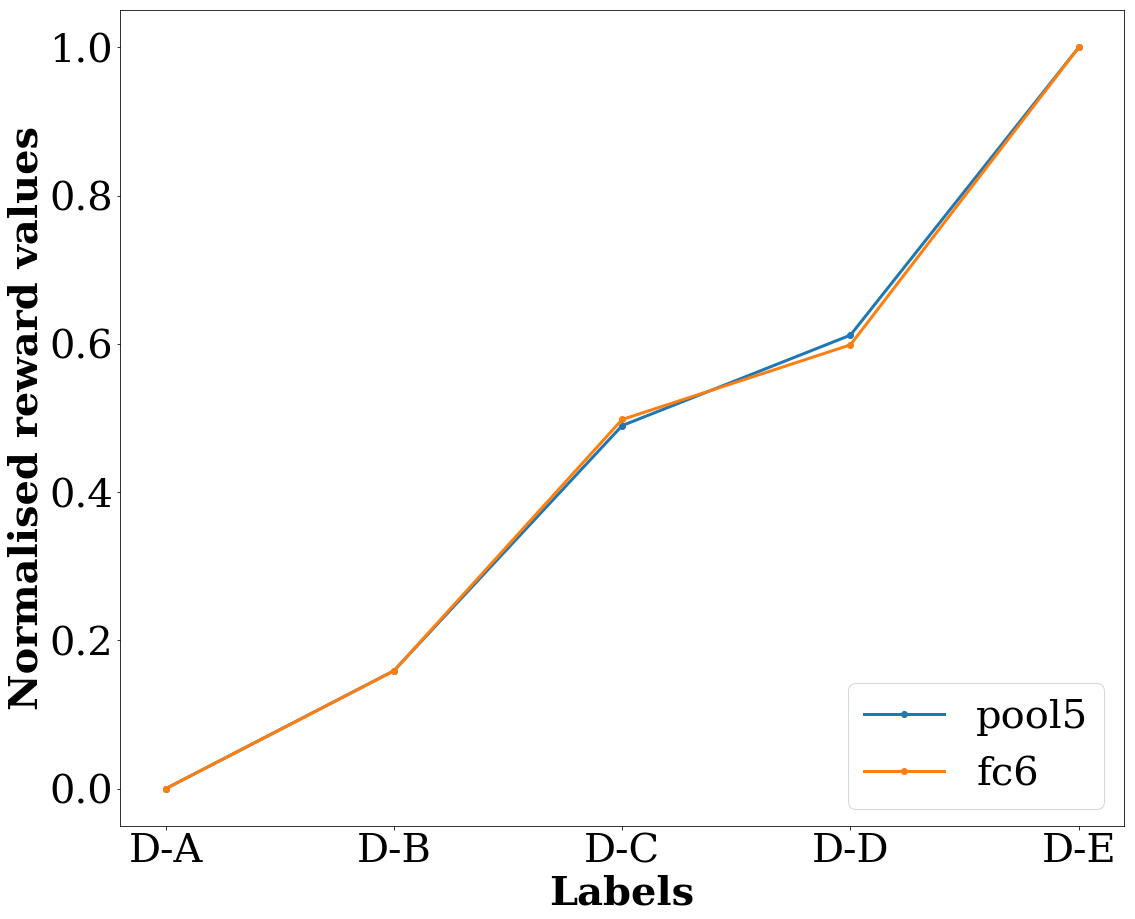

In [34]:
plt.rcParams.update({'font.size': 40})
plt.rcParams["font.family"] = "serif"
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams["figure.figsize"] = [18, 15]
plt.plot(feature_distance_pool5,label='pool5',linewidth=3.0,marker='o')
plt.plot(feature_distance_fc6,label='fc6',linewidth=3.0,marker='o')
plt.ylabel('Normalised reward values') 
plt.xlabel('Labels') 
my_xticks = ['D-A','D-B','D-C','D-D','D-E']
plt.xticks([0,1,2,3,4],my_xticks)
plt.legend(loc='upper right',bbox_to_anchor=(1, 0.2))
plt.show()